# Chest X-Ray Images (Pneumonia)

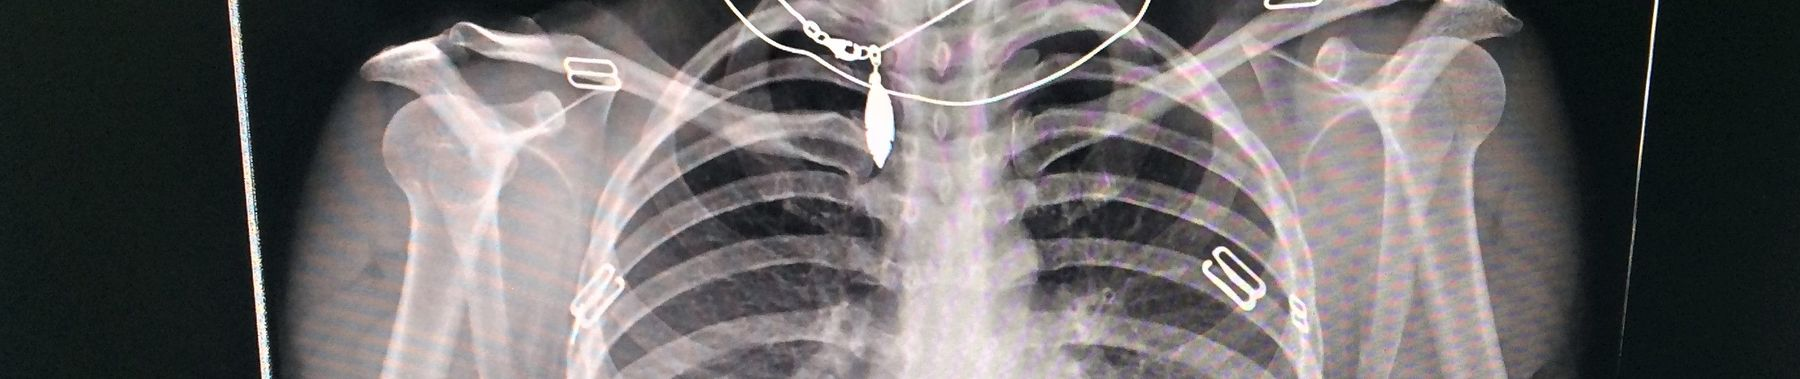

Kacey Clougher, Rachel Goldstein, Irwin Lam, and Kendall McNeil

DESCRIPTION: 

OBJECTIVE: 

DEFINING KEY TERMS:

METHODOLOGY:

# 1. Importing the Data